一、Unet貓狗辨識

In [80]:
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [87]:
# 定義U-net模型
def unet_model(input_shape):
  inputs = Input(input_shape)

  # 編碼器
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  # 中間層
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  # 解碼器
  conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
  merge6 = Concatenate(axis=3)([drop4, up6])
  conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
  conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

  up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
  merge7 = Concatenate(axis=3)([conv3, up7])
  conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
  conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

  up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
  merge8 = Concatenate(axis=3)([conv2, up8])
  conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
  conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

  up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
  merge9 = Concatenate(axis=3)([conv1, up9])
  conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
  conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

  # 輸出層
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

# 下載已經訓練好的模型
model = unet_model(input_shape=(256, 256, 3))
model.save_weights('unet_model_weights.h5')
model.load_weights('unet_model_weights.h5')  # 模型權重的路徑

1/1 [==============================] - 3s 3s/step


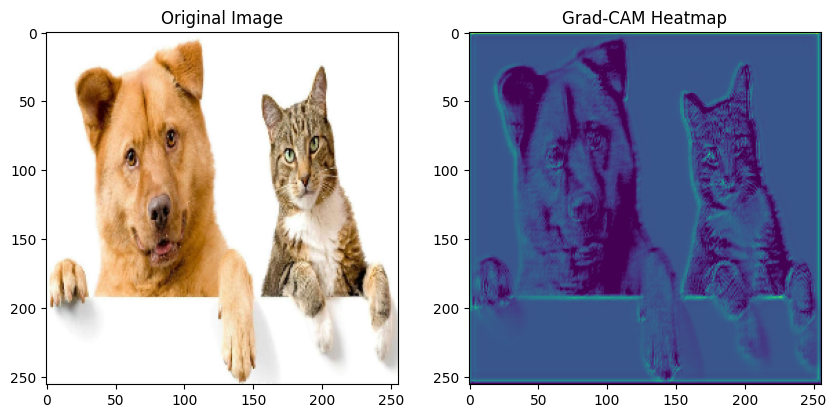

In [98]:
# 下載測試圖片
img = load_img('/content/dog-and-cat.jpg', target_size=(256, 256))
img_array = img_to_array(img) / 255.0  # 把數字變成0-1
img_array = np.expand_dims(img_array, axis=0)

# 使用模型進行預測
prediction = model.predict(img_array)
# model.summary()

# Grad-CAM可視化
def generate_grad_cam(model, img_array, layer_name):
  model_gradcam = Model(inputs=model.input,outputs=[model.get_layer(layer_name).output, model.output])

  with tf.GradientTape() as tape:
    conv_output, predictions = model_gradcam(img_array)
    class_output = predictions[:, 0]

  grads = tape.gradient(class_output, conv_output)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  return heatmap

# 要可視化的模型
layer_name = 'conv2d_230'

# 生成Grad-CAM熱力圖
heatmap = generate_grad_cam(model, img_array, layer_name)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(heatmap[0])
plt.title('Grad-CAM Heatmap')
plt.show()

二、時間序列溫度預測

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv2d_bn(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=3,strides=1,padding=1):
    super(double_conv2d_bn,self).__init__()
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride = strides,padding=padding,bias=True)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size = kernel_size,stride = strides,padding=padding,bias=True)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self,x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    return out

class deconv2d_bn(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=2,strides=2):
    super(deconv2d_bn,self).__init__()
    self.conv1 = nn.ConvTranspose2d(in_channels,out_channels,kernel_size = kernel_size,stride = strides,bias=True)
    self.bn1 = nn.BatchNorm2d(out_channels)

  def forward(self,x):
    out = F.relu(self.bn1(self.conv1(x)))
    return out

class Unet(nn.Module):
  def __init__(self):
    super(Unet,self).__init__()
    self.layer1_conv = double_conv2d_bn(1,8)
    self.layer2_conv = double_conv2d_bn(8,16)
    self.layer3_conv = double_conv2d_bn(16,32)
    self.layer4_conv = double_conv2d_bn(32,64)
    self.layer5_conv = double_conv2d_bn(64,128)
    self.layer6_conv = double_conv2d_bn(128,64)
    self.layer7_conv = double_conv2d_bn(64,32)
    self.layer8_conv = double_conv2d_bn(32,16)
    self.layer9_conv = double_conv2d_bn(16,8)
    self.layer10_conv = nn.Conv2d(8,1,kernel_size=3,stride=1,padding=1,bias=True)
    self.deconv1 = deconv2d_bn(128,64)
    self.deconv2 = deconv2d_bn(64,32)
    self.deconv3 = deconv2d_bn(32,16)
    self.deconv4 = deconv2d_bn(16,8)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    conv1 = self.layer1_conv(x)
    pool1 = F.max_pool2d(conv1,2)
    conv2 = self.layer2_conv(pool1)
    pool2 = F.max_pool2d(conv2,2)
    conv3 = self.layer3_conv(pool2)
    pool3 = F.max_pool2d(conv3,2)
    conv4 = self.layer4_conv(pool3)
    pool4 = F.max_pool2d(conv4,2)
    conv5 = self.layer5_conv(pool4)
    convt1 = self.deconv1(conv5)
    concat1 = torch.cat([convt1,conv4],dim=1)
    conv6 = self.layer6_conv(concat1)
    convt2 = self.deconv2(conv6)
    concat2 = torch.cat([convt2,conv3],dim=1)
    conv7 = self.layer7_conv(concat2)
    convt3 = self.deconv3(conv7)
    concat3 = torch.cat([convt3,conv2],dim=1)
    conv8 = self.layer8_conv(concat3)
    convt4 = self.deconv4(conv8)
    concat4 = torch.cat([convt4,conv1],dim=1)
    conv9 = self.layer9_conv(concat4)
    outp = self.layer10_conv(conv9)
    outp = self.sigmoid(outp)
    return outp

model = Unet()
inp = torch.rand(10,1,224,224)
outp = model(inp)
print(outp.shape)

torch.Size([10, 1, 224, 224])


In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

data = pd.read_csv('jena_climate_2009_2016.csv')

temperature_values = data['T (degC)'].values.reshape(-1, 1)

scaler = MinMaxScaler()
temperature_values = scaler.fit_transform(temperature_values)

train_size = int(len(temperature_values) * 0.67)
test_size = len(temperature_values) - train_size
train_data, test_data = temperature_values[0:train_size, :], temperature_values[train_size:len(temperature_values), :]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, input_shape=(look_back, 1)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(train_X, train_Y, epochs=10, batch_size=64, verbose=2)

train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

--2023-09-22 03:21:51--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.40.216, 16.182.36.88, 16.182.32.200, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.40.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.1MB/s    in 0.6s    

2023-09-22 03:21:52 (21.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  
Epoch 1/10
4402/4402 - 36s - loss: 2.8341e-04 - 36s/epoch - 8ms/step
Epoch 2/10
4402/4402 - 33s - loss: 3.0968e-05 - 33s/epoch - 8ms/step
Epoch 3/10
4402/4402 - 30s - loss: 1.8598e-05 - 30s/epo

Train RMSE: 11.76
Test RMSE: 12.90


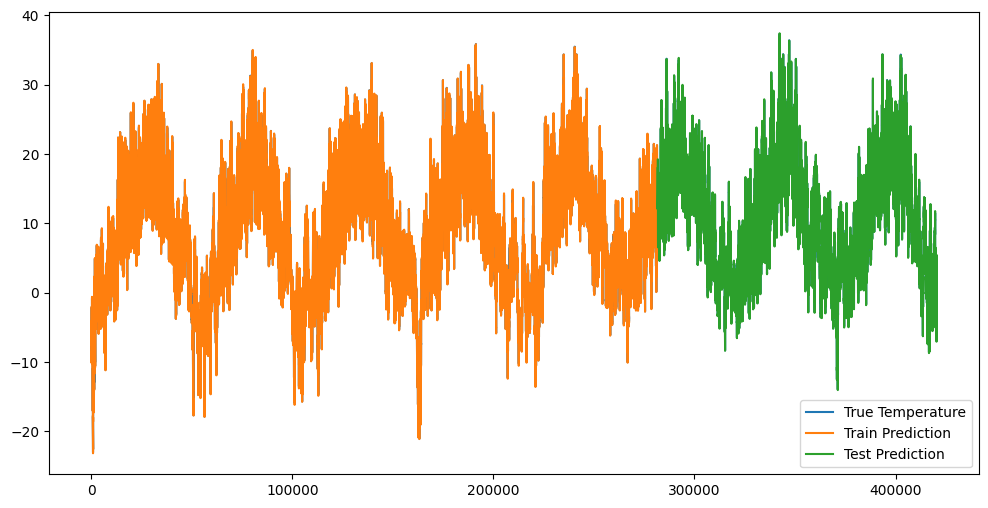

In [101]:
train_score = np.sqrt(mean_squared_error(train_data[look_back:], train_predict))
print(f'Train RMSE: {train_score:.2f}')

test_score = np.sqrt(mean_squared_error(test_data[look_back:], test_predict))
print(f'Test RMSE: {test_score:.2f}')

train_plot = np.empty_like(temperature_values)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict)+look_back, :] = train_predict

test_plot = np.empty_like(temperature_values)
test_plot[:, :] = np.nan
test_predict = test_predict[:len(test_plot)]
test_plot[len(train_predict)+(look_back*2):len(temperature_values), :] = test_predict

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(temperature_values), label='True Temperature')
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')
plt.legend()
plt.show()